# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [ ]:
!nvidia-smi

Fri Mar 24 17:38:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   25C    P8    30W / 300W |      0MiB /  5067MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [ ]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [ ]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [ ]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

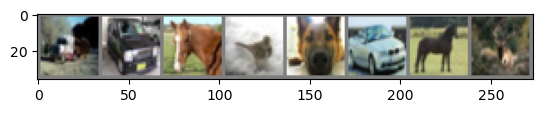

truck car   horse bird  dog   car   horse deer 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [ ]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [ ]:
class Backbone(nn.Module):

  def __init__(self, img_size=IMG_DIM, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
    super(Backbone, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=img_size)
    self.linear = nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
        #nn.Tanh(),
        # nn.LeakyReLU(),
        # nn.Linear(in_features=k, out_features=k, bias=True),  
        # nn.ReLU(),
        nn.Sigmoid(),      # Non Linear Activation
    )
    # self.non_linear = nn.Sigmoid()       # Non Linear Activation
    # self.non_linear = nn.ReLU()

    self.conv2ds = nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        for _ in range(k)
    ])
    self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

  def forward(self, x):
    sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"{sap_out.shape=}")

    g_out = self.linear(sap_out)
    if self.debug: print(f"{g_out.shape=}")
    if self.debug: print(f"{g_out=}")

    outs = list()
    for a, conv2d in zip(g_out.transpose(0, 1), self.conv2ds):
    #for conv2d in self.conv2ds:
      c_out = conv2d(x)
      if self.debug: print(f"{c_out.shape=}")
      if self.debug: print(f"{a.shape=}, \n{a=}")

      out = a.reshape(x.shape[0], 1, 1, 1)*c_out
      if self.debug: print(f"{out.shape=}")
      outs.append(out)
      #outs.append(c_out)
      
    out = sum(outs)
    if self.debug: print(f"{out.shape=}")
    
    out = self.batch_norm(out)
    if self.debug: print(f"{batch_out.shape=}")

    return out

In [ ]:
IMG_SIZE = 32

def find_img_size(initial_img_size=32, depth=4, kernel_size=3, stride=1, pool=2):
    img_sizes = list()
    for i in range(depth):
        dim = initial_img_size
        for d in range(i):
            dim = (dim - kernel_size) // stride
        img_sizes.append(dim)
        
    return img_sizes

find_img_size()

[32, 29, 26, 23]

In [ ]:
class Model(nn.Module):

  def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug
    self.Ks = Ks
    self.channels = channels
    self.img_sizes = [(IMG_DIM + (STRIDE-kernel_size)*i) for i in range(n+1)]
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)

    if self.debug: print(f"{self.channels=}")
    if self.debug: print(f"{self.img_sizes=}")
    if self.debug: print(f"{self.Ks=}")
    if self.debug: print(f"{n=}")

    self.backbones = nn.ModuleList([
        Backbone(
            img_size=self.img_sizes[i], 
            in_channels=self.channels[i], 
            out_channels=self.channels[i+1], 
            kernel_size=kernel_size, 
            k=self.Ks[i], 
            debug=debug
        ) 
        for i in range(n)
    ])

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.linear = nn.Sequential(
        # nn.Linear(in_features=self.channels[-1], out_features=self.channels[-1] * 2 // 3, bias=False),
        # nn.Dropout(p=0.2),
        # nn.ReLU(),
        # nn.Linear(in_features=self.channels[-1] * 2 // 3, out_features=self.channels[-1] // 3, bias=False),
        # nn.Dropout(p=0.2),
        # nn.ReLU(),
        # nn.Linear(in_features=self.channels[-1] // 3, out_features=len(CLASSES), bias=False),
        nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False),
    )
    # self.linear = nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False)

  def set_debug(self, debug=True):
    self.debug = debug
    for backbone in self.backbones:
      backbone.debug = debug

  def forward(self, x):
    for backbone in self.backbones:
      x = backbone(x)
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out

In [ ]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, epochs, trainloader, testloader, logs_per_epoch=4) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader

        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
    
    def train(self, use_gpu=False):
        
        correct = 0
        total = 0
        
        for epoch in range(self.epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            print(f"Train Loss : {self.losses[-1]}")
            
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            self.eval()

        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 3)

        X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')

        ax2.plot(self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        plt.tight_layout()
        fig.show()
    

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

## Experiment

In [ ]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 64, 128, 256, 512] #19, ]
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)
if USE_GPU: model.to('cuda')

model

self.channels=[3, 64, 128, 256, 512]
self.img_sizes=[32, 29, 26, 23, 20]
self.Ks=[3, 3, 3, 3]
n=4


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=32, stride=32, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): B

In [ ]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.15)

model.set_debug(False)

In [ ]:
# Init Trainer

EPOCHS = 3
BATCH_SIZE = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=EPOCHS, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/782 [00:00<?, ?it/s]

[1,   195] loss: 1.693
[1,   390] loss: 1.326
[1,   585] loss: 1.216
[1,   780] loss: 1.157
Train Loss : 1.3483765934739271
Train Accuracy : 51.61 %
Val Loss : 1.1463463002709067
Accuracy of the network on the 10000 test images: 59.10 %


Epoch 2 :   0%|          | 0/782 [00:00<?, ?it/s]

[2,   195] loss: 1.062
[2,   390] loss: 1.034
[2,   585] loss: 0.969
[2,   780] loss: 0.937
Train Loss : 1.000674691727704
Train Accuracy : 58.18 %
Val Loss : 0.9602443777072202
Accuracy of the network on the 10000 test images: 65.69 %


Epoch 3 :   0%|          | 0/782 [00:00<?, ?it/s]

[3,   195] loss: 0.894
[3,   390] loss: 0.872
[3,   585] loss: 0.852
[3,   780] loss: 0.830
Train Loss : 0.8618931198668907
Train Accuracy : 62.03 %
Val Loss : 0.8216063444781455
Accuracy of the network on the 10000 test images: 70.64 %
Finished Training


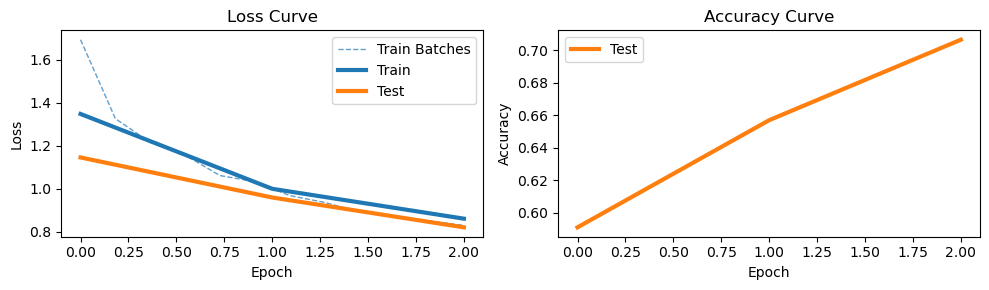

In [ ]:
trainer.epochs = 3

trainer.train(use_gpu=USE_GPU)
trainer.plot()

Epoch 1 :   0%|          | 0/782 [00:00<?, ?it/s]

[1,   195] loss: 0.787
[1,   390] loss: 0.778
[1,   585] loss: 0.766
[1,   780] loss: 0.750
Train Loss : 0.771815503611589
Train Accuracy : 72.79 %
Val Loss : 0.777108294758827
Accuracy of the network on the 10000 test images: 72.35 %


Epoch 2 :   0%|          | 0/782 [00:00<?, ?it/s]

[2,   195] loss: 0.704
[2,   390] loss: 0.688
[2,   585] loss: 0.723
[2,   780] loss: 0.698
Train Loss : 0.7031534734894248
Train Accuracy : 74.19 %
Val Loss : 0.7132143962914776
Accuracy of the network on the 10000 test images: 74.75 %


Epoch 3 :   0%|          | 0/782 [00:00<?, ?it/s]

[3,   195] loss: 0.638
[3,   390] loss: 0.644
[3,   585] loss: 0.648
[3,   780] loss: 0.618
Train Loss : 0.6368925762374688
Train Accuracy : 75.41 %
Val Loss : 0.6712800607939434
Accuracy of the network on the 10000 test images: 76.45 %


Epoch 4 :   0%|          | 0/782 [00:00<?, ?it/s]

[4,   195] loss: 0.571
[4,   390] loss: 0.589
[4,   585] loss: 0.586
[4,   780] loss: 0.586
Train Loss : 0.582723715916619
Train Accuracy : 76.47 %
Val Loss : 0.6267071334040089
Accuracy of the network on the 10000 test images: 78.00 %


Epoch 5 :   0%|          | 0/782 [00:00<?, ?it/s]

[5,   195] loss: 0.522
[5,   390] loss: 0.544
[5,   585] loss: 0.530
[5,   780] loss: 0.548
Train Loss : 0.5357291258661948
Train Accuracy : 77.48 %
Val Loss : 0.6145561772167303
Accuracy of the network on the 10000 test images: 78.62 %


Epoch 6 :   0%|          | 0/782 [00:00<?, ?it/s]

[6,   195] loss: 0.477
[6,   390] loss: 0.491
[6,   585] loss: 0.495
[6,   780] loss: 0.480
Train Loss : 0.4858592786180699
Train Accuracy : 78.43 %
Val Loss : 0.5822704265451735
Accuracy of the network on the 10000 test images: 79.87 %


Epoch 7 :   0%|          | 0/782 [00:00<?, ?it/s]

[7,   195] loss: 0.434
[7,   390] loss: 0.444
[7,   585] loss: 0.464
[7,   780] loss: 0.450
Train Loss : 0.44806084406497837
Train Accuracy : 79.29 %
Val Loss : 0.5783603206561629
Accuracy of the network on the 10000 test images: 80.25 %


Epoch 8 :   0%|          | 0/782 [00:00<?, ?it/s]

[8,   195] loss: 0.392
[8,   390] loss: 0.424
[8,   585] loss: 0.417
[8,   780] loss: 0.412
Train Loss : 0.4110732637631619
Train Accuracy : 80.09 %
Val Loss : 0.5446100569075081
Accuracy of the network on the 10000 test images: 81.56 %


Epoch 9 :   0%|          | 0/782 [00:00<?, ?it/s]

[9,   195] loss: 0.364
[9,   390] loss: 0.377
[9,   585] loss: 0.385
[9,   780] loss: 0.390
Train Loss : 0.37874908587130746
Train Accuracy : 80.85 %
Val Loss : 0.5665776619485988
Accuracy of the network on the 10000 test images: 80.52 %


Epoch 10 :   0%|          | 0/782 [00:00<?, ?it/s]

[10,   195] loss: 0.318
[10,   390] loss: 0.339
[10,   585] loss: 0.378
[10,   780] loss: 0.368
Train Loss : 0.35143058678454453
Train Accuracy : 81.56 %
Val Loss : 0.5158178319407117
Accuracy of the network on the 10000 test images: 82.34 %


Epoch 11 :   0%|          | 0/782 [00:00<?, ?it/s]

[11,   195] loss: 0.311
[11,   390] loss: 0.314
[11,   585] loss: 0.335
[11,   780] loss: 0.346
Train Loss : 0.3277186798050885
Train Accuracy : 82.20 %
Val Loss : 0.5303390995142566
Accuracy of the network on the 10000 test images: 81.92 %


Epoch 12 :   0%|          | 0/782 [00:00<?, ?it/s]

[12,   195] loss: 0.287
[12,   390] loss: 0.291
[12,   585] loss: 0.302
[12,   780] loss: 0.318
Train Loss : 0.2994233278933998
Train Accuracy : 82.83 %
Val Loss : 0.5154391579377423
Accuracy of the network on the 10000 test images: 82.76 %


Epoch 13 :   0%|          | 0/782 [00:00<?, ?it/s]

[13,   195] loss: 0.248
[13,   390] loss: 0.273
[13,   585] loss: 0.300
[13,   780] loss: 0.312
Train Loss : 0.2832448833891193
Train Accuracy : 83.40 %
Val Loss : 0.5060395723695208
Accuracy of the network on the 10000 test images: 82.91 %


Epoch 14 :   0%|          | 0/782 [00:00<?, ?it/s]

[14,   195] loss: 0.237
[14,   390] loss: 0.259
[14,   585] loss: 0.292
[14,   780] loss: 0.286
Train Loss : 0.26871199051246925
Train Accuracy : 83.93 %
Val Loss : 0.5097717718713602
Accuracy of the network on the 10000 test images: 83.12 %


Epoch 15 :   0%|          | 0/782 [00:00<?, ?it/s]

[15,   195] loss: 0.214
[15,   390] loss: 0.238
[15,   585] loss: 0.287
[15,   780] loss: 0.288
Train Loss : 0.25727977298790844
Train Accuracy : 84.42 %
Val Loss : 0.5034991167722993
Accuracy of the network on the 10000 test images: 82.88 %


Epoch 16 :   0%|          | 0/782 [00:00<?, ?it/s]

[16,   195] loss: 0.208
[16,   390] loss: 0.236
[16,   585] loss: 0.254
[16,   780] loss: 0.276
Train Loss : 0.24300489468914468
Train Accuracy : 84.87 %
Val Loss : 0.5477922650848984
Accuracy of the network on the 10000 test images: 82.26 %


Epoch 17 :   0%|          | 0/782 [00:00<?, ?it/s]

[17,   195] loss: 0.202
[17,   390] loss: 0.222
[17,   585] loss: 0.255
[17,   780] loss: 0.265
Train Loss : 0.2362193599953066
Train Accuracy : 85.30 %
Val Loss : 0.5179609244416474
Accuracy of the network on the 10000 test images: 82.76 %
Finished Training


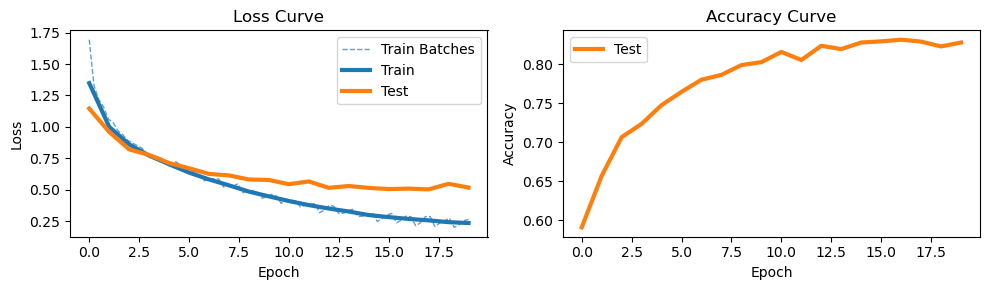

In [ ]:
trainer.epochs = 17

trainer.train(use_gpu=USE_GPU)
trainer.plot()